In [215]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [216]:
import sys
sys.path.append('../')
import adaprobe

In [217]:
fontsize=13

In [246]:
fname = '201118_cell1_A'

In [247]:
data = np.load('data/one_cell_per_plane_plus_10_random_%s.npz'%fname)

In [248]:
y = data['y']
stimulus_matrix = data['stimulus_matrix']
y_psc = data['y_psc']
N, K = stimulus_matrix.shape
trial_length = y_psc.shape[1]
n_repeats = K//N

In [249]:
ispectra = np.array([np.max(scipy.signal.correlate(y_psc[i], y_psc[i])) for i in range(K)])

In [250]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

fit_options = {
    'iters': 100,
    'num_mc_samples': 20,
    'seed': 0,
#     'lam_mask': 
}

model = adaprobe.Model(np.zeros(N), priors=priors)

In [251]:
model.reset()
model.fit(y, stimulus_matrix, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

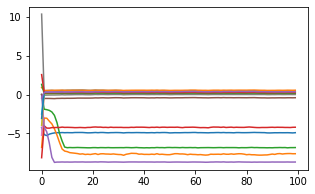

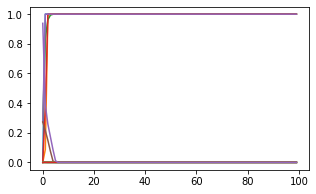

In [252]:
plt.figure(figsize=(5, 3))
plt.plot(model.history['mu'])
# plt.legend(range(N))
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(model.history['alpha'])
plt.show()

In [253]:
lam = np.array(model.state['lam']).T
alpha = np.array(model.state['alpha'])

phi = model.state['phi']
phi_cov = model.state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - phi_sdevs
phigh = phi + phi_sdevs

In [254]:
Irng = np.arange(0, 91)

In [255]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
postmax = np.max(post)

In [256]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [257]:
N = 9

<ipython-input-261-761dea8c325b>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


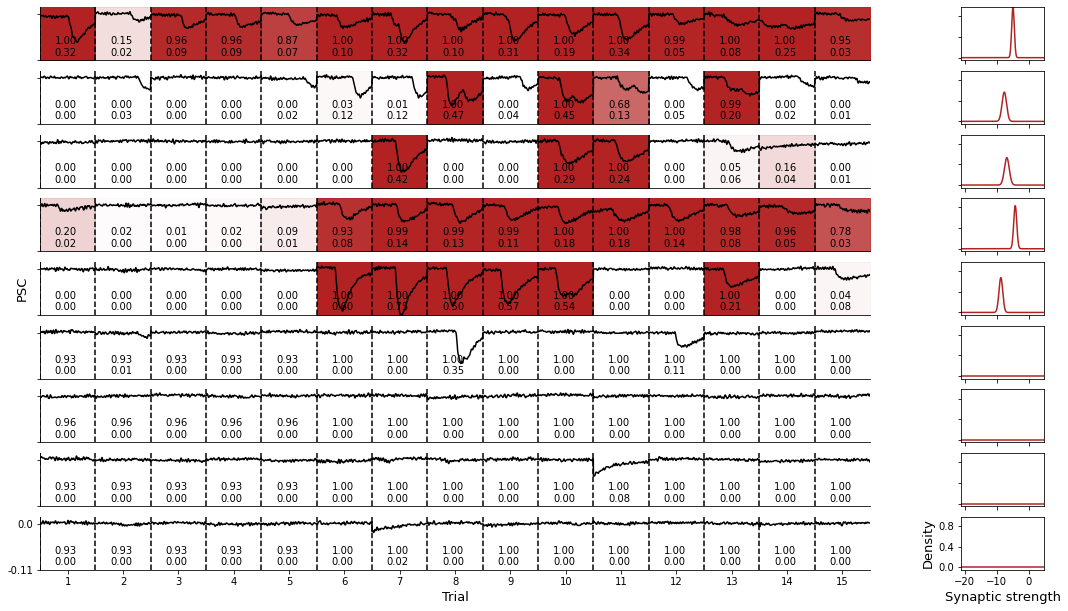

In [261]:
trial_breaks = np.arange(0, trial_length * n_repeats + 1, trial_length)

plt.figure(figsize=(18, 1.15 * N))
gs = gridspec.GridSpec(N, 2, width_ratios=[15, 1.5])
    
for n in range(N):
    # Spike predictions
    plt.subplot(gs[n, 0])
    stim_locs = np.where(stimulus_matrix[n] > 0)[0]
    this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
    fill_lower = -1
    fill_upper = 0.15
    plt.xlim([0, trial_length*n_repeats])
    plt.ylim([-1, 0.15])
    for tb in range(len(trial_breaks) - 1):
        plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
        plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb] * alpha[n])
        plt.text(trial_breaks[tb] + trial_length/2 - 70, -0.9, '%.2f\n%.2f'%(lam[n, stim_locs][tb], ispectra[stim_locs][tb]))
    plt.plot(this_y_psc, color='k')
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    
    if n == N-1:
        plt.xticks(trial_breaks[:-1] + trial_length/2)
        plt.gca().set_xticklabels(np.arange(1, n_repeats+1))
        plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
        plt.xlabel('Trial', fontsize=fontsize)
    elif n == N//2:
        plt.ylabel('PSC', fontsize=fontsize)
        plt.xticks([])
        plt.gca().set_yticklabels([])
    else:
        plt.xticks([])
        plt.gca().set_yticklabels([])
        
    # Synapses
    plt.subplot(gs[n, 1])
    plt.plot(xrange, post[n], color='firebrick')
    plt.xlim(np.min(xrange), np.max(xrange))
    plt.ylim([-0.05, postmax])
    if n < N-1:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    else:
        plt.xlabel('Synaptic strength', fontsize=fontsize)
        plt.ylabel('Density', fontsize=fontsize)
    plt.xticks(np.arange(-20, 1, 10))
    plt.yticks([0, 0.4, 0.8])
    
#     # Spike-power relationship
#     plt.subplot(gs[n, 2])
#     if alpha[n] < 0.5:
#         sigcol = 'gray'
#     else:
#         sigcol = 'firebrick'
#     plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color=sigcol)
#     plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor=sigcol, edgecolor='None', alpha=0.25)
#     if n == N-1:
#         plt.xlabel('Power', fontsize=fontsize)
#         plt.ylabel('Spike prob', fontsize=fontsize)
#     else:
#         plt.gca().set_xticklabels([])
#         plt.gca().set_yticklabels([])
#     plt.xticks([0, 45, 90])
    
# plt.savefig('figs/one_cell_per_plane_plus_10_random_trunc_to_N%i_%s.png'%(N, fname), format='png', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

In [259]:
np.round(alpha, 7)

array([1.       , 1.       , 0.9999999, 1.       , 1.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       ])

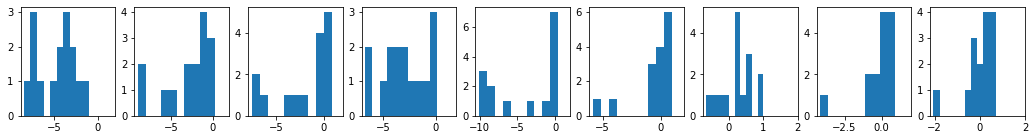

In [260]:
panel_size = 2
plt.figure(figsize=(panel_size * N, panel_size))
for n in range(N):
    plt.subplot(1, N, n+1)
    trial_locs = np.where(stimulus_matrix[n] > 0)[0]
    plt.hist(y[trial_locs])
    plt.xlim(right=2)
plt.show()